In [1]:
# general imports usually needed
import numpy as np
import matplotlib as mpl
import matplotlib.animation
import matplotlib.pyplot as plt
import seaborn as sbn
import pandas as pd

In [2]:
# libraries more specific to this lecture notebook
import os.path
import sys
sys.path.append('../../src')
from ml_python_class.config import DATA_DIR

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [3]:
# notebook wide settings to make plots more readable and visually better to understand
np.set_printoptions(suppress=True)

#%matplotlib widget
#%matplotlib inline

plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('figure', titlesize=18)
plt.rc('legend', fontsize=14)
plt.rcParams['figure.figsize'] = (12.0, 8.0) # default figure size if not specified in plot
plt.style.use('seaborn-v0_8-darkgrid')


# 4. (Chapter 4) Training Models

In this chapter we will begin our study of Machine Learning algorithms in earnest.  Up
to this point you have gotten a taste of using some ML models as black boxes.
You don't really know internally what they are doing or how they work.  But still, learning
the API of how to create data sets and set up models for training, and knowning in
general what supervisied learning is and how you train a model to fit a dataset is
sufficient to start working with ML.

However, at some point you will be working with a dataset and you will get some
weird or unexpected results.  Also there are myriads of parameters and hyper-parameters,
not to mention issues with formatting and cleaning your data, and tweaking
training procedures, etc. that will all always be a bit mysterious and/or you will only
learn by wrote checklists, if you don't understand some of the fundamentals of the
internal implemenations of the various ML algorithms you use.

Understanding whats under the hood will help you quickly understand what types of ML
models will be promising or not for the data you have.  It will give you an understanding
of the hyper-parameters the model uses, and what you might want to try for these parameters
to get good results.  Understanding whats under the hood will also allow you to debug
and spot issues you have with training and debugging your models.  It will allow you
to perform error analysis, and better understand why your models may be working, and why
they may be failing, so that you can tweak things to improve their performance.

In short, while you can be a push-button/check-list using data analyst, if you eventually
want to improve your skills and become a better data scientist, you need to start
learning the internal working of ML algorithms.  Our goal in this class is to begin
your journey along this path.  We won't become experts on any of the ML methods we 
will look at, but we hope to introduce you to the fundamental concepts and inner
workings, so that you can beging to understand more deeply how the techniques work.

In this chapter, and units of our course, we will begin by looking at **linear regression**
(which we have used already), followed by **logistic regression**.  These units are very
important, as these models have basic concepts that are often similar across many types
of ML algorithms.  We will look at the idea of the **cost function** (or **fitness function**),
and how this can be used with techniques like **gradient descent** to fit the parameters
of a model in general to make predictions about a set of data.  Linear regression
is a technique for performing regression modeling (predict real valued outputs), while
logistic regression is useful for classification (despite its name, which is a bit
misleading at best).  By comparing similarities and differences of cost functions and
fitting models between regression and classification tasks, we will illustrate some general
principles of ML that apply to many types of supervisied learning models, whether
regression or classification tasks.

## 4.1 Linear Regression

Linear regression is a technique to fit a line (linear model) to a set of data
points.  A linear model assumes a linear relationship between the attributes
and the value we wish to predict.  Linear relationships are common, though not
all system outputs are simple linear combinations of their inputs.

In the simplest case, we could have a single attribute $x$
and single value we want to predict $y$.  In our HOML textbook, the author
gave an example using GDP and life satisfaction in chapter 1.

Here is another example.  In the following dataset we want to try and relate
the size of a house (in square feet) to its selling price.

In [4]:
# load data into pandas dataframe
house = pd.read_csv('../../data/housing-prices-portland-or.csv')
house.drop('bedrooms', axis=1, inplace=True) # we are not using bedrooms attribute in this example
house.price = house.price / 1000.0 # specify house price in 1000s $

# use x and y for convenience
y = house.price.values
x = house.sqft.values

In [5]:
print(type(x))
print(x.shape)
print(y.shape)

<class 'numpy.ndarray'>
(47,)
(47,)


In [6]:
x_column = x.reshape(-1,1)
print(x_column.shape)

(47, 1)


In [7]:
house.describe()

,sqft,price
count,47.000000,47.00000
mean,2000.680851,340.41266
std,794.702354,125.03990
min,852.000000,169.90000
25%,1432.000000,249.90000
50%,1888.000000,299.90000
75%,2269.000000,384.45000
max,4478.000000,699.90000


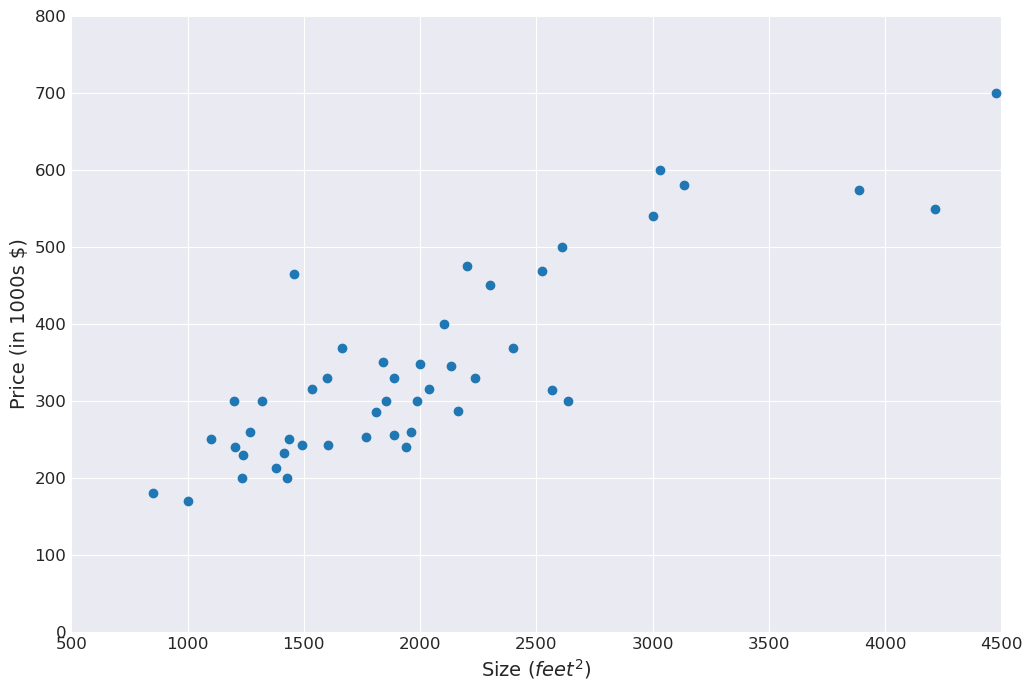

In [8]:
# display scatter plot of the data
plt.scatter(x, y)
plt.axis([500, 4500, 0, 800])
plt.xlabel('Size ($feet^2$)')
plt.ylabel('Price (in 1000s $)');

The data looks like it might reasonably have a linear relationship, e.g. for each change in
size of the house by 1 square foot, there is probably a constant increase in the
price of the house.

You probably at some point learned (and may have forgotten), how to define a line
that goes through 2 given points of data.  For example, the first two points of our
house data are these points.

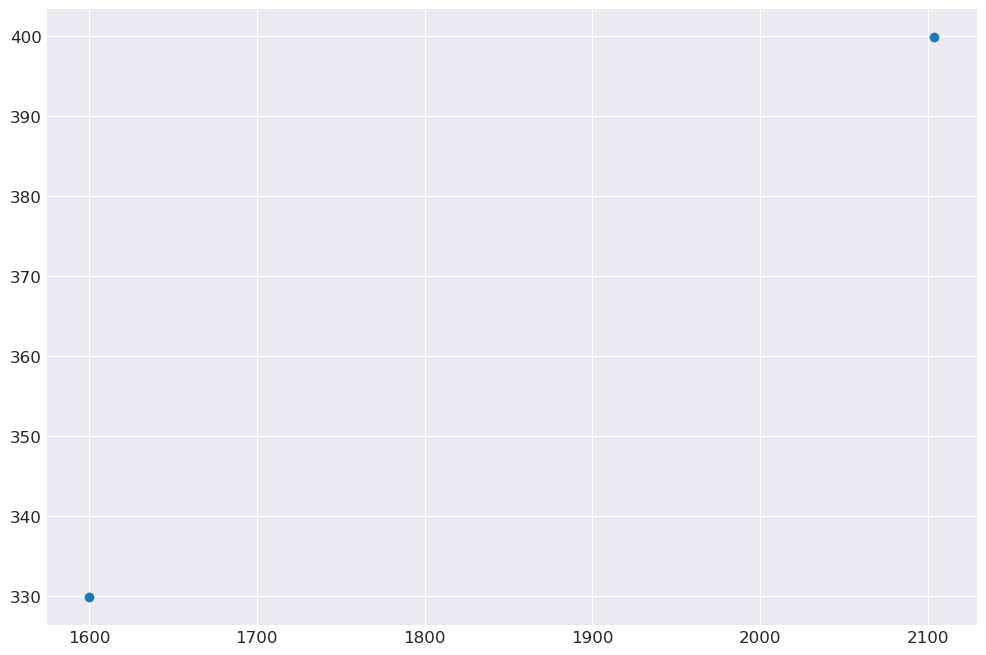

In [9]:
# plot only the first 2 points
plt.scatter(x[:2], y[:2]);

We can find a line that fits these points perfectly (goes through both of them), since
two points define a line, using the slope-intercept equation.

$$
y = b + mx
$$

where $m$ represents the slope of the line, and $b$ the y-intercept of the line (the value
of $y$ when $x = 0$).

The slope of the line, in case you have forgotten, is the change in $y$ divided by the
change in $x$, which we can find easily enough for our two points.

In [10]:
# difference of y divided by differnce of x is our slope
m = (y[1] - y[0]) / (x[1] - x[0])
m

0.1388888888888889

There are infinitely many lines with a slope of $m = 0.1389$, so we need to find the value
of the other parameter $b$ to find the one line with that slope that goes through these
points.  We can do that by rearranging the slope-intercept equation and using either of
our points to determine $y$

$$
b = y - mx
$$

In [11]:
# determine the intercept
b = y[0] - m * x[0]
b

107.67777777777775

So this gives an intercept of $107.6$ (thousands of dollars).

With our parameters $m$ and $b$ we can visualize the line that goes through these 2 points.

In [21]:
x_points = np.linspace(1500, 2200, 2)
y_points = b + m * x_points

(-100.0, 2200.0, -100.0, 500.0)

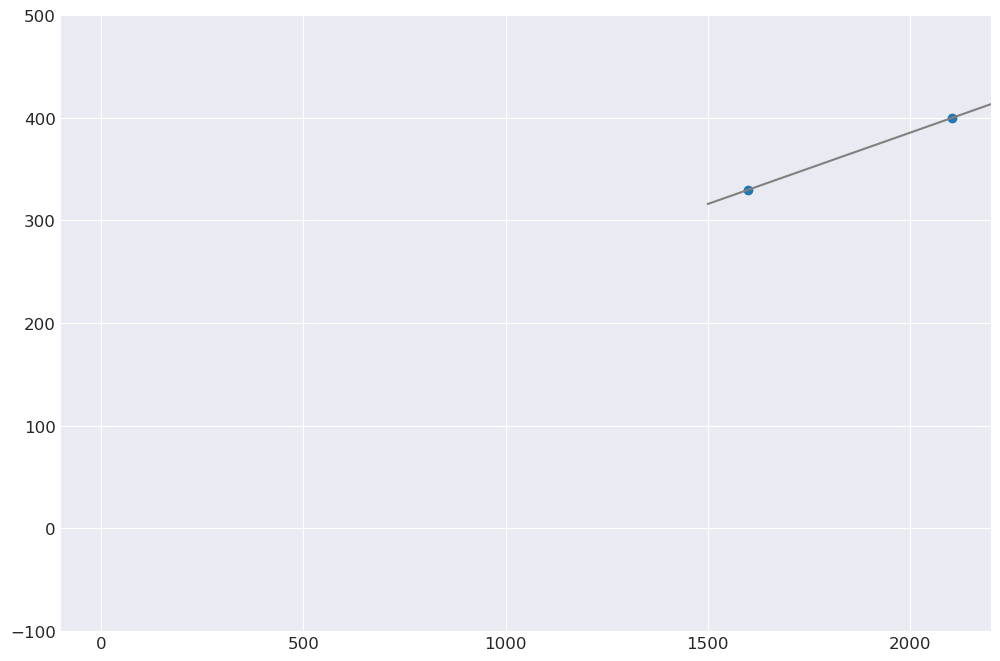

In [22]:
# plot the 2 points on the line
plt.scatter(x[:2], y[:2]);

# plot the line we determined goes through them
plt.plot(x_points, y_points, 'grey');
plt.axis([-100, 2200, -100, 500])

Of course this line fits the two points perfectly, it goes through both of them so the
error at each point of the model line is 0.

But what if we have 3 points?

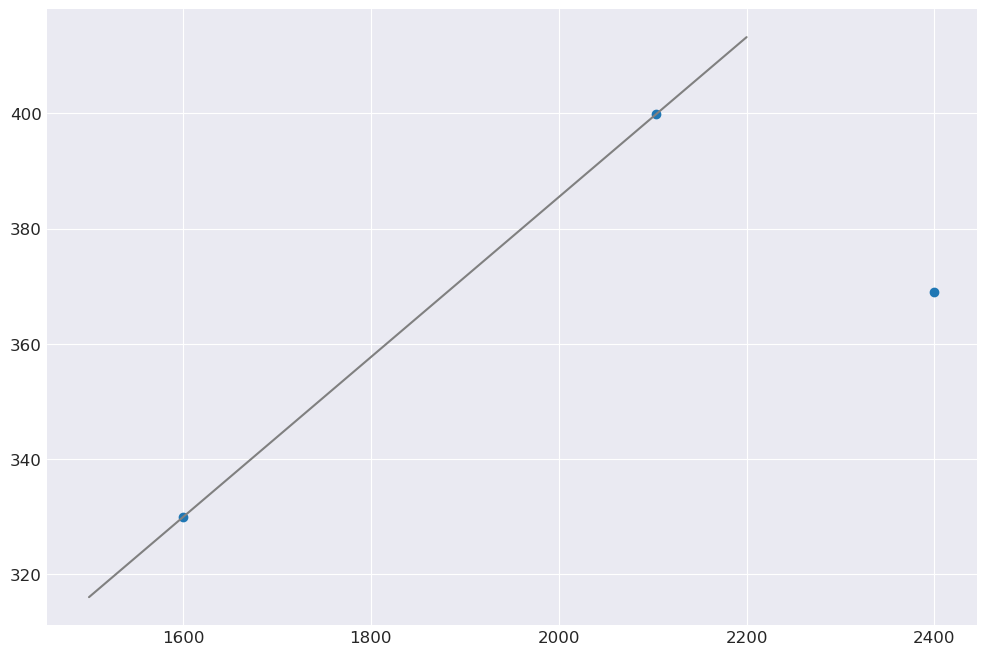

In [23]:
# plot the first 3 points
plt.scatter(x[:3], y[:3]);

# plot the line we determined goes through the first 2 points we were using
plt.plot(x_points, y_points, 'grey');

What is the line that best fits these 3 points?  Should it instead go through the point 
at $(1600, 330)$ and the new point?  Or should it not go through any of the points but 
between all of them?  What we need is a **cost function**, a formal measurement of the 
"fittedness"  of a line with regard to a set of points we believe have a linear
relationship.

Our line for these first two points may or may not be a good fit for the data as a whole.

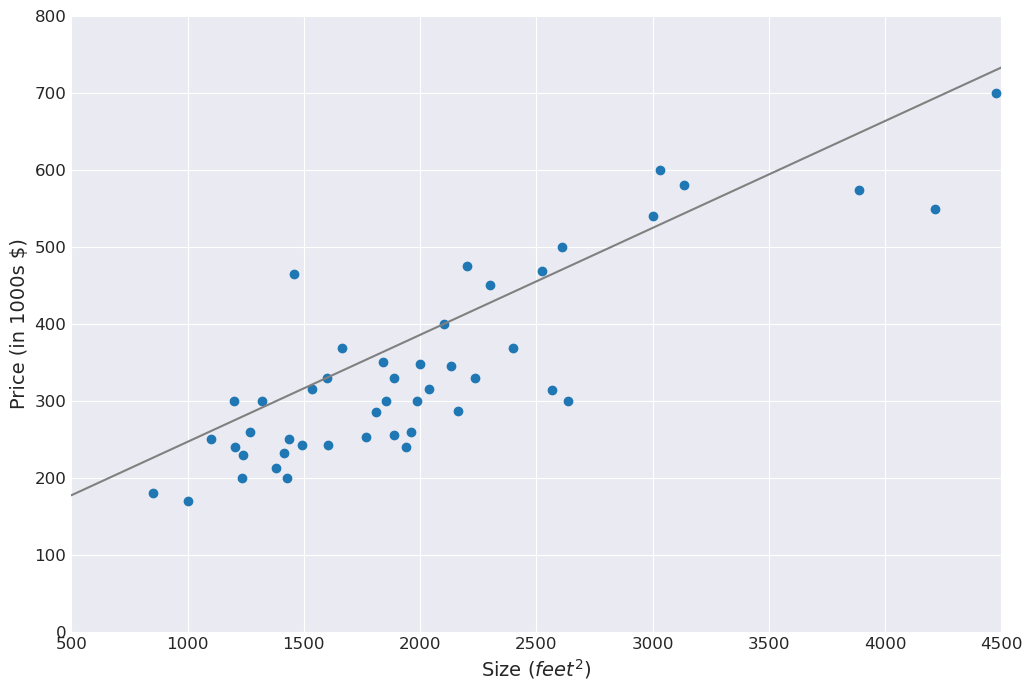

In [24]:
# display scatter plot of the data
plt.scatter(x, y)
plt.axis([500, 4500, 0, 800])
plt.xlabel('Size ($feet^2$)')
plt.ylabel('Price (in 1000s $)');

# display the line we fit for the first 2 points again, extend the line for the
# range from 500 to 3100 now
x_points = np.linspace(500, 4500, 100)
y_points = b + m * x_points
plt.plot(x_points, y_points, 'grey');

The line in this case doesn't look too bad, the slope may be about right, though the intercept
looks like it might be better if we lowered it.  We will talk about a way to formalize
the idea of "fitedness" with a cost function in a bit.  But we have seen previously
a method that will determine the paramters $m$ and $b$ that is the "best fit" for a line
by some cost measure, the `np.polyfit()` function.  Here is the best fit line
from the standard linear regression cost function for this data, plotted with the data and our
original line of the first 2 points we calculated.

$$
y = mx^1 + b
$$

In [25]:
# polyfit fits a nth degree polynomial to the data x to predict y.
# using n=1 means fit a degree 1 polynomial, e.g. a line
(m_best, b_best) = np.polyfit(x, y, 1)
print('slope = ', m_best)
print('intercept = ', b_best)

slope =  0.1345252877202413
intercept =  71.27049244872903


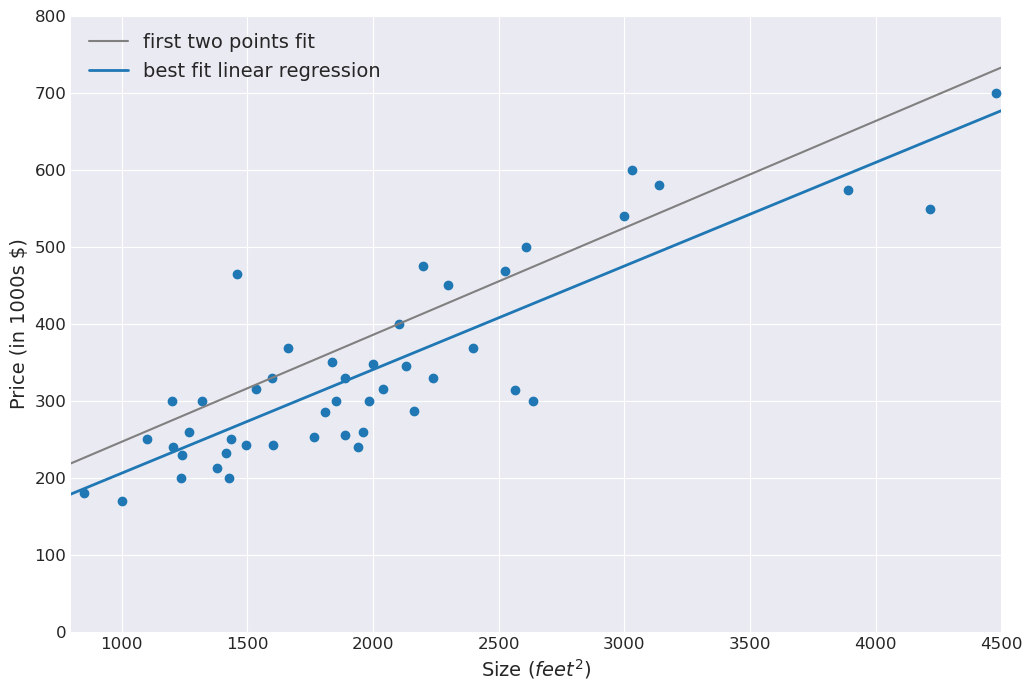

In [27]:
# display scatter plot of the data
plt.scatter(x, y)
plt.axis([800, 4500, 0, 800])
plt.xlabel('Size ($feet^2$)')
plt.ylabel('Price (in 1000s $)');

# display the line we fit for the first 2 points again, extend the line for the
# range from 500 to 3100 now
x_points = np.linspace(500, 4500, 2)
y_points = b + m * x_points
plt.plot(x_points, y_points, 'grey', label='first two points fit');


# now display the actual best fit line as determined by linear regression
x_points = np.linspace(500, 4500, 100)
y_best = b_best + m_best * x_points
plt.plot(x_points, y_best, 'C0', lw=2.0, label='best fit linear regression');

plt.legend();

As we said the slope was not too far off, though that was just luck.  Lots of pairs of
points of course give very different slopes, even slopes perpindicular to the
best fit line.

BTW, the seaborn library has a plot specifically designed for creating a scatter plot
of data with a possible linear relationship, display the best fit linear regression
model, and also giving a calculated error bounds around the best fit line.

/opt/anaconda3/envs/jupyterhub/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


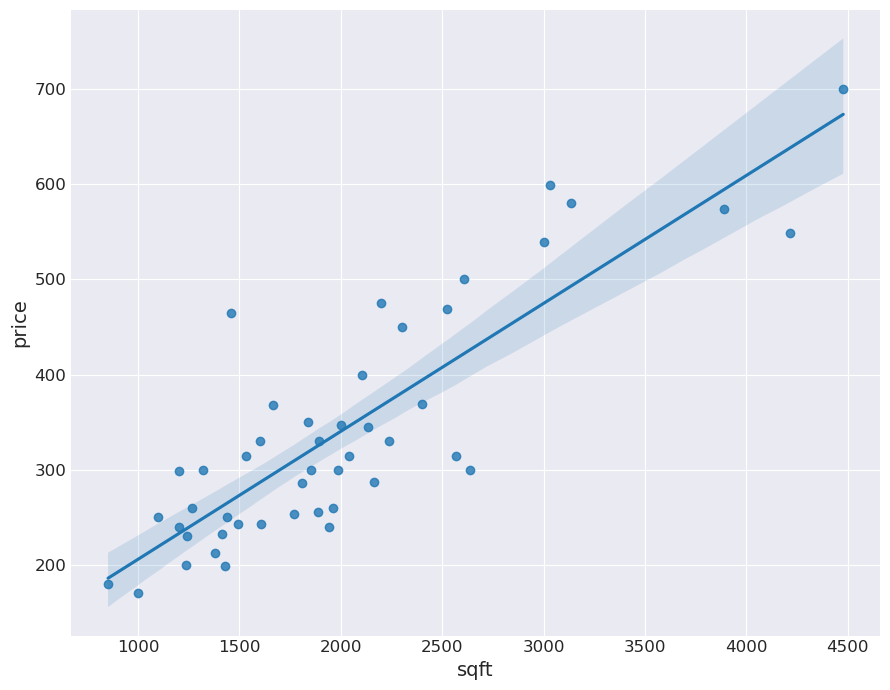

In [28]:
sbn.lmplot(x='sqft', y='price', data=house, height=7, aspect=9.0/7.0);

Before we talk about the cost function and how to fit the parameters, lets change our notation
a bit and generalize the model a bit.

In general, for ML models, we think of $m$ and $b$ as **parameters** of the model that need
to be **fit**.  Different values of the parameters give different **hypothesis** functions.
For example, we showed two hypothesis functions, the model where we fit the first 2 lines
gives one set of predicitions for each house size over the range of values.  The best
fit model using linear regression gives another set of hypothesis over this range.

In general ML academics like to use $\theta$ (greek letter Theta) as the names for all of the
parameters.  So the general equation of a line is really our hypothesis or prediction
function, given some set of parameters.  Formally we write it like this:

$$
\hat{y} = \theta_0 + \theta_1 x_1
$$

Where we have the following.

- $\hat{y}$ is the predicted value.  We use $y$ for the actual data values we are trying to
predict, and $\hat{y}$ for values generated from a hypothesis function like our linear
model here.
- $\theta_0$ is the **intercept term** of our model.  In general many other models have 
a term like this that is not a product of any of the features, and in general it is often
referred to as the **bias term**.
- $\theta_1$ is the slope of our linear model with a single attribute (house size in square 
feet).
- $x_1$ is our first (and only) **feature** or **attribute** of this data.
The data has a single feature $x_1$ which is the size of a house in square feet,
and a single output or value we want to predict $y$ which is the price of the house.
- $n$ is the **number of features** or attributes of the model.  So far this model has
only a single feature so $n = 1$
- $m$ is the **number of samples** or **number of experiments** in the dataset.
We didn't mention, but as you can see from the output of `describe()` this
data set contains a set of 47 houses, so $m = 47$.  As we mentioned in
previous videos, usually our data tables or DataFrames have $m$ rows of samples of
data by $n$ columns of features we will use for prediction.

Most of the time we will be working with data with many more features than $n = 1$ in it.
But the technique for linear regression (and other ML techniques) easily and directly
generalizes to fitting a linear model to multi-dimensional data (e.g. we are fitting a
plane when $n=2$ and a hyperplane when $n > 3$).  The general form of the linear
regression model equation for $n$ attributes is:

$$
\hat{y} = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \cdots + \theta_n x_n
$$

Where $x_1, x_2, \cdots, x_n$ are the $n$ attributes of the model we are trying to
linearly fit to our data $y$.

This general form of the linear regression model can be written more concisely using
a vectorized form (from linear algebra, see the review of linear algebra video
now to be introduced to some of these concepts).

$$
\hat{y} = h_\theta(x) = \theta \cdot x
$$

- $h_\theta(x)$ is the hypothesis function for a set of paramters $\theta$.
- $\theta$ is the model's **parameter vector**, containing the bias term $\theta_0$ and
the feature weights $\theta_1$ to $\theta_n$.  
- $x$ is the **feature vector**, containing $x_0$ to $x_n$.  Notice we didn't have
a $x_0$ before, here $x_0$ is always equal to 1.
- $\theta \cdot x$ is the dot product of the vectors $\theta$ and $x$, which of course
comes out to $\theta_0 x_0 + \theta_1 x_1 + \theta_2 x_2 + \cdots + \theta_n x_n$.

Lets give an example of using this vectorized form to try and make what we are doing clearer.
We already have a perfectly good way to represent a vectorized hypothesis using NumPy
and vectorized operations as we did previously.  But we can also perform the same
calculation in the following way.

For example, the $\theta$ vector represents a single hypothesis.  Lets create a NumPy
array (a vector) of the best fit hypothesis we had determined above for our data
with $n = 1$ feature. 

In [29]:
Theta = np.array([b_best, m_best])
print(Theta)
print(Theta.shape)

[71.27049245  0.13452529]
(2,)


To perform a matrix/matrix multiplication we need the x values that we would like predictions for.
For example, we could see how our hypothesis parameters `Theta` predict the set of 47 actual
house sizes we have in our data. 

But we also need a feature matrix $X$ and we need to add the bias term as an additional
column.  The result should be a `(47,2)` shaped matrix where column 0 represents the $x_0$
values, and is all 1's.

**NOTE**: this is what `scikit` learn for example expects the `X` input matrix to be
shaped as, with features/attributes as columns, and the samples in the rows.
This differs slightly from using column vectors, which our textbook briefly
mentions.  But in short it means when we calculate the hypothesis shortly,
we will modify the equation or order slightly because of our matrix shapes,
but the result is the same calculation.

In [30]:
n = 1
m = len(x)

# create an matrix of of m rows still, but n+1 columns so we can add in the bias/intercept
# feature as column 0
X = np.ones( (m, n+1) )


# assign column 1 to be the 47 house sizes we want to make predictions of
X[:, 1] = x

print(X)
print(X.shape)

[[   1. 2104.]
 [   1. 1600.]
 [   1. 2400.]
 [   1. 1416.]
 [   1. 3000.]
 [   1. 1985.]
 [   1. 1534.]
 [   1. 1427.]
 [   1. 1380.]
 [   1. 1494.]
 [   1. 1940.]
 [   1. 2000.]
 [   1. 1890.]
 [   1. 4478.]
 [   1. 1268.]
 [   1. 2300.]
 [   1. 1320.]
 [   1. 1236.]
 [   1. 2609.]
 [   1. 3031.]
 [   1. 1767.]
 [   1. 1888.]
 [   1. 1604.]
 [   1. 1962.]
 [   1. 3890.]
 [   1. 1100.]
 [   1. 1458.]
 [   1. 2526.]
 [   1. 2200.]
 [   1. 2637.]
 [   1. 1839.]
 [   1. 1000.]
 [   1. 2040.]
 [   1. 3137.]
 [   1. 1811.]
 [   1. 1437.]
 [   1. 1239.]
 [   1. 2132.]
 [   1. 4215.]
 [   1. 2162.]
 [   1. 1664.]
 [   1. 2238.]
 [   1. 2567.]
 [   1. 1200.]
 [   1.  852.]
 [   1. 1852.]
 [   1. 1203.]]
(47, 2)


Now given a `(1, 2)` shaped column vector of the hypothesis parameters
and a `(47,2)` shaped matrix of the features `X`, we can use the dot product
(matrix multiplication) to calculate the hypothesis simultaneously for all of these
house prices we want a prediction for.  

**NOTE**: this differs slightly from the books formulation because we have 
formatted our `X` array with each sample in a row.  Thus to get the correct
vectorized matrix multiplication, if we `transpose()` X instead here, we
end up with a `(2,)` shaped vector multiplied by a `(2,47)` transposed shaped
X matrix, which is defined for matrix multiplication.

In [31]:
yhat = np.dot(Theta, X.T)
print(yhat)
print(yhat.shape)

[354.31169781 286.5109528  394.13118298 261.75829986 474.84635561
 338.30318857 277.63228381 263.23807803 256.9153895  272.2512723
 332.24955063 340.32106789 325.52328624 673.67473086 241.84855728
 380.67865421 248.84387224 237.54374807 422.24696811 479.01663953
 308.97667585 325.25423566 287.04905395 335.20910696 594.57386168
 219.24830894 267.40836194 411.08136923 367.22612543 426.01367617
 318.66249657 205.79578017 345.7020794  493.27632003 314.89578851
 264.5833309  237.94732393 358.07840587 638.29458019 362.1141645
 295.12057122 372.33808637 416.59690603 232.70083771 185.88603759
 320.41132531 233.10441358]
(47,)


Or instead of transposing X, we chould just rearrange the order of X and Theta
in the matrix multiplication.  The result is still the same calculation.

In [32]:
np.dot(X, Theta)

array([354.31169781, 286.5109528 , 394.13118298, 261.75829986,
       474.84635561, 338.30318857, 277.63228381, 263.23807803,
       256.9153895 , 272.2512723 , 332.24955063, 340.32106789,
       325.52328624, 673.67473086, 241.84855728, 380.67865421,
       248.84387224, 237.54374807, 422.24696811, 479.01663953,
       308.97667585, 325.25423566, 287.04905395, 335.20910696,
       594.57386168, 219.24830894, 267.40836194, 411.08136923,
       367.22612543, 426.01367617, 318.66249657, 205.79578017,
       345.7020794 , 493.27632003, 314.89578851, 264.5833309 ,
       237.94732393, 358.07840587, 638.29458019, 362.1141645 ,
       295.12057122, 372.33808637, 416.59690603, 232.70083771,
       185.88603759, 320.41132531, 233.10441358])

In [33]:
y_hat = np.dot(Theta, X.T)
print(y_hat.shape)

(47,)


This last cell was basically a vectorized form of the hypothesis function calculation.
We can compare our hypothesized values to the actual values in a plot.  Since we used
the `Theta` parameters of the best fit line, our hypothesized points will be on that
best fitting linear model of the data:

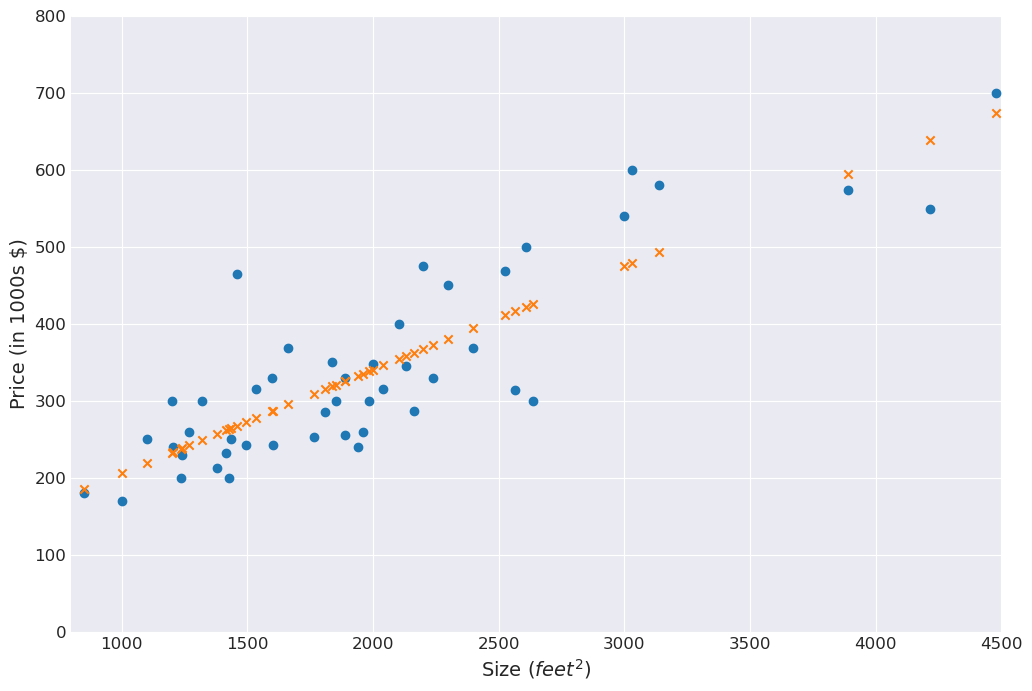

In [34]:
# display scatter plot of the data
plt.scatter(x, y)
plt.axis([800, 4500, 0, 800])
plt.xlabel('Size ($feet^2$)')
plt.ylabel('Price (in 1000s $)');

# display the prediction points that result from our best fit hypothesis function
plt.scatter(x, y_hat, marker='x', c='C1');

These are the predictions for our best fit `Theta` parameters, you should be able to see
that each house size has a corresponding predicted price.  This is the best prediction we
can make in some sense from our fitted linear model.  Why this is "best" will be discussed
next.

So you may be wondering, why are we using this matrix-multiplication vectorized
method for calculating the hypothesis, when we can simply do.

In [35]:
y_hat = b_best + m_best * x
y_hat.shape

(47,)

The answer is that, while this works for $n = 1$ or 5 or so features, imagine a real
dataset where you might have 100's or 1000's of features (or now a-days millions is
not unreasonable).  In that case you have to use linear algebra and matrix representations
to represent your hypothesis parameters and your feature values as matrices that you want to
generate a hypothesis for, as you would not be able to express this operation in code in any
easily written way without thinking of it as a matrix multiplication operation.

### Cost Function

Ok that is the hypothesis function of the linear regression model.  But up to this point we have been
avoiding answering how exactly do we determine what it means to be the "best fitting" linear model
for some set of data.

Looking at the previous figure, it should be intuitive that the further away a prediction is from the
true price, the worse the prediction is.  So for example given one point and its prediction, we can
determine how good the prediction is by simply doing:

In [37]:
print('actual:    ', y[0])
print('predicted: ', y_hat[0])
print('error:     ', y_hat[0] - y[0])

actual:     399.9
predicted:  354.31169781211673
error:      -45.588302187883244


First of all its really the magnitude of this difference that is important.  So when we under
predict like here really the fact we were a bit over 45 (thousand) dollars off for this predictions is
what is important.  Smaller would be better, 0 error means we predict it perfectly.

But how we do on a single prediction isn't the whole story.  We want to know how we did predicting
**ALL** of the values.  We can use a vectorized subtraction to get all of our prediction errors in
one go.

In [38]:
error = y_hat - y
print(error)

[ -45.58830219  -43.3890472    25.13118298   29.75829986  -65.05364439
   38.40318857  -37.26771619   64.23907803   44.9153895    29.7512723
   92.25055063   -6.67893211   -4.47571376  -26.22526914  -18.05144272
  -69.22134579  -51.05612776   37.64374807  -77.75103189 -119.98336047
   56.07667585   70.25423566   44.14905395   75.30910696   20.67386168
  -30.65169106 -197.09163806  -57.91863077 -107.77387457  126.11367617
  -31.23750343   35.89578017   30.8020794   -86.62367997   28.99578851
   14.6833309     8.04732393   13.07840587   89.29458019   75.1141645
  -73.37942878   42.43808637  102.59690603  -66.29916229    5.98603759
   20.51132531   -6.39558642]


Sometimes we were too high, sometimes too low.  We want one single overall objective measure that tells
us how close to an error of 0 we are getting over all of the dataset samples.  We could just sum
up the errors.

In [39]:
np.sum(error)

-4.575895218295045e-12

The error is (basically) 0, which is very misleading.  We are off by almost $200k for example in one prediction.
We really want a sum of the **magnitude** of the error.  An obvious first idea is to just use the absolute
value.

In [40]:
np.sum(np.abs(error))

2444.2262579345606

This is known as the absolute error.

And if you want a feel for the average amount you are off for each prediction, we could simply
divide this by the number of samples to get the mean absolute error **MAE**.

In [41]:
np.sum(np.abs(error)) / m

52.00481399860767

So our best fit line has prediction errors (according to the MAE cost function) on average of $\pm 52$ thousand dollars here.

The MAE is an example of a cost function.  It tells us how well our model is doing in
making predictions (on the data we fitted the model with in this case).
The mean absolute error is not the one most commonly used as a cost function for ML training.
Instead we use the mean squared error **MSE**.  The reason why MSE is preferred is
for mathematical tractability, which we may go into more detail later, but basically
taking the derivative of a quadratic (square) function results in a smooth function, where
derivatives of functions with absolute values have discontinuities and are thus much messier to work
with analytically.

The full equation for the MSE cost function can be summarized as the following:

$$
\text{MSE}(X, h_{\theta}) = \frac{1}{m} \sum_{i=0}^{m-1} \big( \theta x^{(i)} - y^{(i)}  \big)^2
$$

Lets break this down a bit.  The MSE is a function of a set of attributes $X$ you want to evaluate
the cost of, and your hypothesis function $h_{\theta}$, which is a hypothesis for a fixed and determined
set of $\theta$ parameters, representing your model or hypothesis.

Our text added the notation $x^{(i)}$ and $y^{(i)}$.  This justs represents accessing the $i^{th}$ houses data as a
column vector in $X$, or the $i^{th}$ house label in $y$.  So for example, for $i = 0$
we have

In [42]:
# x^(i) means the ith value of X here, so it is just an array index
# since each row in our X is a sample item, we get the ith sample like this
i = 0
X[i]

array([   1., 2104.])

In [43]:
# and y^(i) is simply the ith output label, so it is
y[i]

399.9

An asstute student may have noticed that I changed the summation from our textbook to sum from
$i = 0$ to $m - 1$ instead of from $1$ to $m$.  This is because in Python NumPy arrays we use
0 based indexing, so it is more natural to express our summations starting at index 0.

Also notice this part of the MSE

$$
\theta x^{(i)}
$$

This is simply calculating the hypothesis on the $i^{th}$ sample in the data `X`.  So since
$\hat{y}^{(i)} = \theta x^{(i)}$ we could also think of MSE as

$$
\text{MSE}(X, h_{\theta}) = \frac{1}{m} \sum_{i=0}^{m-1} \big( \hat{y}^{(i)} - y^{(i)}  \big)^2
$$

So really all we want to do is sum up the squares of the differences between the hypothesis
and the true value here.  So that is pretty similar to what we did before, just using the
square (quadratic) instead of the absolute value.

In [44]:
# the sum of the squared error
np.sum(error**2.0)

193464.4776007059

In [45]:
# the average of sum squared error
np.sum(error**2.0) / m

4116.265480866083

In this case, the average of our sum squared errors is still a squared value, so you can't really
directly compare this to our `y` labels since the units are different.  But we can take 
the square root, to give us what is known as the root mean squared error **RMSE**

In [46]:
# the square root of the average of sum squared error
# taking square root means answer is back in same units as our original data 'y'
np.sqrt(np.sum(error**2.0) / m)

64.15812872010906

This will differ from the **MAE** since we are squaring the error magnitudes instead of taking the
absolute value.  Squaring the errors has another effect besides being more mathematically
tractable.  Large errors have more effect on the final sum of the cost function.  Thus the **MSE**
will tend to be a bit more sensitive to large errors (and outliers) than the **MAE**.

Finally to put this all together, the MSE equation above suggests how we can compute
the MSE in a vectorized way given hypothesis $\theta$ and the data $X$ we want to estimate the
cost of.  We can do all of the operations in a single step like this:

In [48]:
error = np.dot(Theta, X.T) - y
mse = np.sum(error**2.0) / m
print('Mean Square Error: ', mse)
print('Root Mean Square Error: ', np.sqrt(mse))

Mean Square Error:  4116.265480866083
Root Mean Square Error:  64.15812872010906


And this represents the basic steps of a typical cost function for ML.  We calculate the error, which
are the difference between prediction and the label in supervised learning.  Then we sum up the
magnitude of the errors, where we calculate the magnitude using absolute value or the square of the
errors.  Dividing this sum by the number of samples gives the average or mean of this summed error.

### The Normal Equation

To fully understand this section it is suggested you work through and review basic
concepts from Linear Algebra.  I have a notebook and video materials available for you
to start with.

So the question you should be asking your self at this point is: "How does the
linear regression algorithm determine the values of the $\theta$ parameters
that result in the optimal cost?"  

If we didn't make it clear before, the MSE cost we demonstrated will be the very lowest
cost you can achieve using a squared error cost function on this set of 47 points.
But how do we know you can't get any lower cost with some slightly different set
of $\theta$ model parameters?

One way we can achieve this is analytically, using the **Normal Equation**.
An analytical solution is not always possible for a Machine Learning
algorithm or other statistical method.  But for the case of a linear equation, we
can use vector/matrix linear algebra to exactly solve and find the best
$\theta$ parameters for the data.

The normal equation can be expressed like this:

$$
\hat{\theta} = \big( X^T X\big)^{-1} X^T y
$$

Where

- $\hat{\theta}$ is the value of $\theta$ that minimizes the cost function.
- $X$ is still our matrix of attributes, with the added column of 1's for the
intercept/bias term.
- $y$ is the vector of the target values.
- $Z^{-1}$ represents the inverse matrix operation, $Z^T$ is just a matrix transpose.

Fully deriving this equation is beyond the scope of this class, but here is a general
description of how it is done.  If you start with the MSE cost function, we 
want to find the values of $\theta$ that give the minimal cost.  If this was
a simple quadratic equation, we would normally do this by taking the derivative
of the equation, and solving the derivative to find the values of $\theta$ that
result in a derivative of 0.  Because when the derivative (or slope or gradient)
is 0, that means you are either at a minimum or a maximum of the function.
And further, since we are using a quadratic equation here, that means there is
a single minimum or maximum, and in this case it will always be a minimum.
Thus solving for where the derivative is 0 of the cost function will determine
the values of the $\theta$ parameters that minimize the cost.  The normal equation
shown here is derived in the same way, by finding the derivative of the linear
algebraic representation of the MSE cost function, and solving for where that
derivative is 0.

We can verify the normal equation expression ourself on the data we are currently
using.  We already have `X` and `y` in the column matrix forms we need.

In [49]:
print(X.shape)
print(y.shape)

(47, 2)
(47,)


And recall, according to the `np.polyfit()` function, which is probably using some
form of the normal equation to calculate the parameters analytically, the best fit
theta paramters were (intercept at y=71.27, slope of m=0.1345):

In [50]:
Theta

array([71.27049245,  0.13452529])

So lets calculate the best fit theta paramters analytically ourselves using the normal
equation.  Here instead of using `np.dot()` function I will switch to the overloaded
`@` operator which will perform matrix multiplication the same as the dot function, but 
allows us to directly express the same normal equation in code.  But there is no
notation for the inverse, so we need to use the `np.linalg.inverse()` function to calculate
the inverse of the resulting matrix.

In [51]:
my_Theta = np.linalg.inv(X.T @ X) @ X.T @ y
my_Theta

array([71.27049245,  0.13452529])

We have actually already using linear regression previously.  Above we performed 
a linear regression using the `np.polyfit()` function.  We used the `LinearRegression`
from sklearn in a previous lecture.  Doing a regression using sklearn is fairly
simple.  Although, sklearn will add the bias term for you, so we need to pass in
a matrix X of our features without the bias / intercept term again.

In [52]:
from sklearn.linear_model import LinearRegression

X = house.sqft.values.reshape( (-1,1) ) # shapes into a m rows by 1 column matrix which is what we need here 
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(71.2704924487291, array([0.13452529]))

As a final example before we move on, it is often useful to use fake data to better
understand how ML modeling works.  For example, we can generate a data set where
we know the true slope and intercept $\theta$ coefficients.  We don't know what the
true parameters are for our house price data.  In fact, we don't really know for sure
if a linear relationship between the two variables is the best model, or if something
else might work better.  In theory and practice, even if we know that the relationship
between the variables is linear, it will be impossible to ever exactly recover the
parameters of the real data, because noise from measurement and other factors will
always obscure the relationship.

An example with made up data can make this concept clearer.  Lets create some made up
data where we know the true values of the slope and intercept parameters that we
will use to generate the points.  We will add some random noise into each point,
to demonstrate that the best fit will only be an approximation of the true
parameters (if it really is a linear function).

For example, lets create data with an intercept of 4 and a slope of 3.  

We start with just a selection of random X attributes that range from 0 to 2.0.
We create a `(100, 1)` shaped matrix of these values.

In [53]:
X = 2.0 * np.random.rand(100, 1)
print(X.shape)
print(X.min())
print(X.max())

(100, 1)
0.0026617277773475223
1.996437308498625


Now we create our target data.  The dependent variable has a linear relationship
with our independent `X`feature, with a slope of 3 and an intercept of 4 as we said.  
But we also add a bit of random noise (with a normal distribution, so with a mean of 0 and
a standard deviation of 1).

In [54]:
# y is a linear function of x with intercept term of 4 and slope of 3
y = 4.0 + 3.0 * X

# but the relationship is noisy, we add a bit of gaussian noise to each value
y = y + np.random.randn(100, 1)

print(y.shape)
print(y.min())
print(y.max())

(100, 1)
3.49057722954889
10.934308488506982


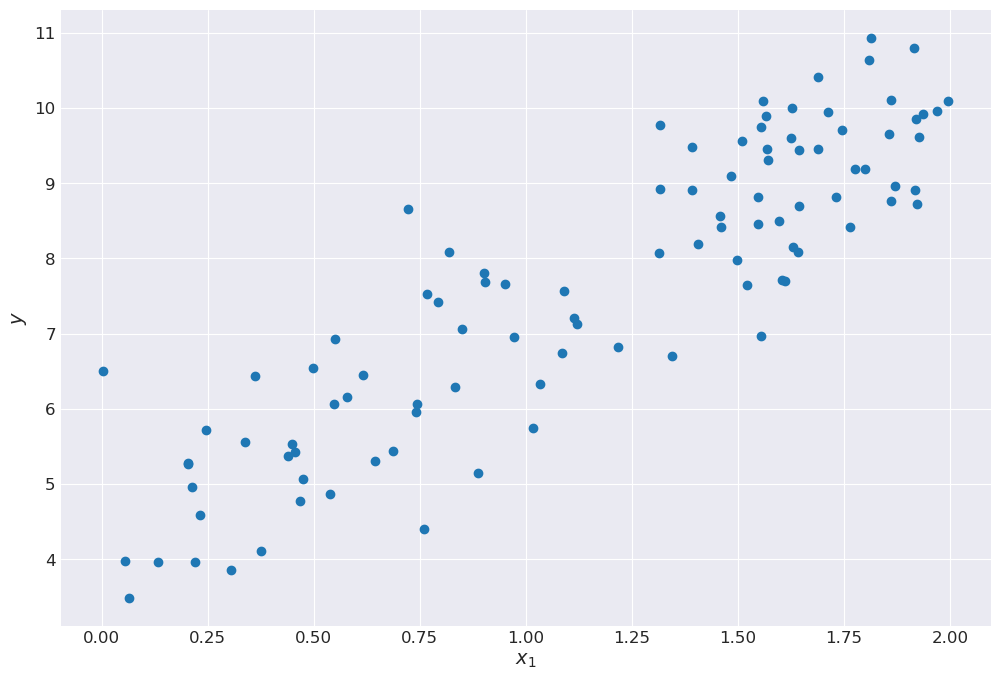

In [55]:
# plot the randomly generated dataset 
plt.scatter(X, y);
plt.xlabel('$x_1$')
plt.ylabel('$y$');

Now lets compute the $\theta$ best fit parameters using all 3 methods of linear
regression that we have seen so far.

Lets start by doing it by hand using the normal equation.  For the normal equation,
we have to have a matrix `X` that includes a column of bias terms, so we add
that first, then compute using the normal equation.

In [56]:
X_b = np.concatenate( (np.ones((100,1)), X), axis=1)

In [57]:
theta_normaleq = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y
theta_normaleq

array([[4.23426585],
       [2.91991289]])

Now lets try using `np.polyfit()`

In [58]:
theta_polyfit = np.polyfit(X.flatten(), y, 1)
theta_polyfit

array([[2.91991289],
       [4.23426585]])

Now use sklearn `LinearRegression` predictor.

In [59]:
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.23426585]), array([[2.91991289]]))

Although not always in the same order (you'll have to read the functions/methods
carefully to determine the bias term from the other theta parameters),
you should see they all get the same
fit of our function.  Lets show the best fit predictions using the sklearn
`predict()` function.

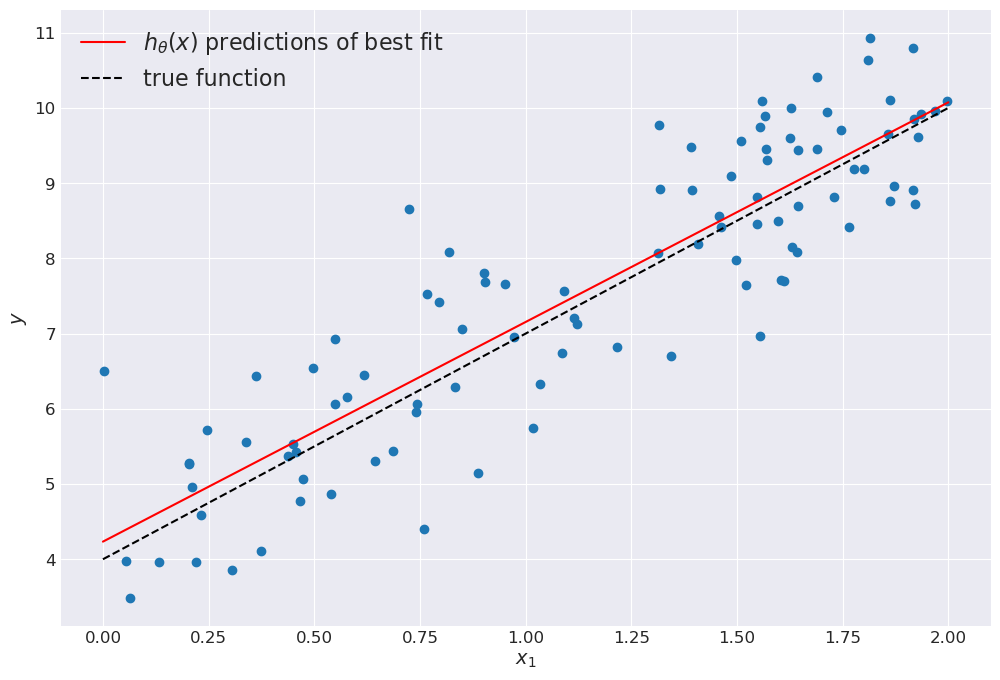

In [60]:
# plot the randomly generated dataset 
plt.scatter(X, y);
plt.xlabel('$x_1$')
plt.ylabel('$y$')

# to plot the prediction of a line, really only need 2 points on the line, so we choose
# the endpoints of the known range
x_new = np.array([[0], [2]])


# plot the prediction
y_hat = lin_reg.predict(x_new)
plt.plot(x_new, y_hat, 'r-', label=r'$h_{\theta}(x)$ predictions of best fit')

# plot the true function line
y_actual = 4.0 + 3.0 * x_new
plt.plot(x_new, y_actual, 'k--', label=r'true function')

plt.legend(fontsize=16);

Since the data is generated randomly you may see a slightly different fit each time you
run.  The slope will be close to 3 and intercept close to 4, but never exact, and always
different.  Rerunning this example is also instructive because it teaches us something
about experimental sampling.  Imagine we are sampling 100 samples from a population
that has the true linear relationship with added noise we know created this data.
You know that your fit will not be exact.  But the amount of noise in your data
and other statistical properties will allow you to not only fit a linear model, but 
give estimates on how close the model is to the true parameters (i.e. the confidence
interval shown in the seaborn `lmplot()`.

**Side Example** In fact, if we sample 100 times and plot the best fit line,
you can see basically the same kind of confidence interval will be formed
that you can get from regular statistical analysis of the sampled data.

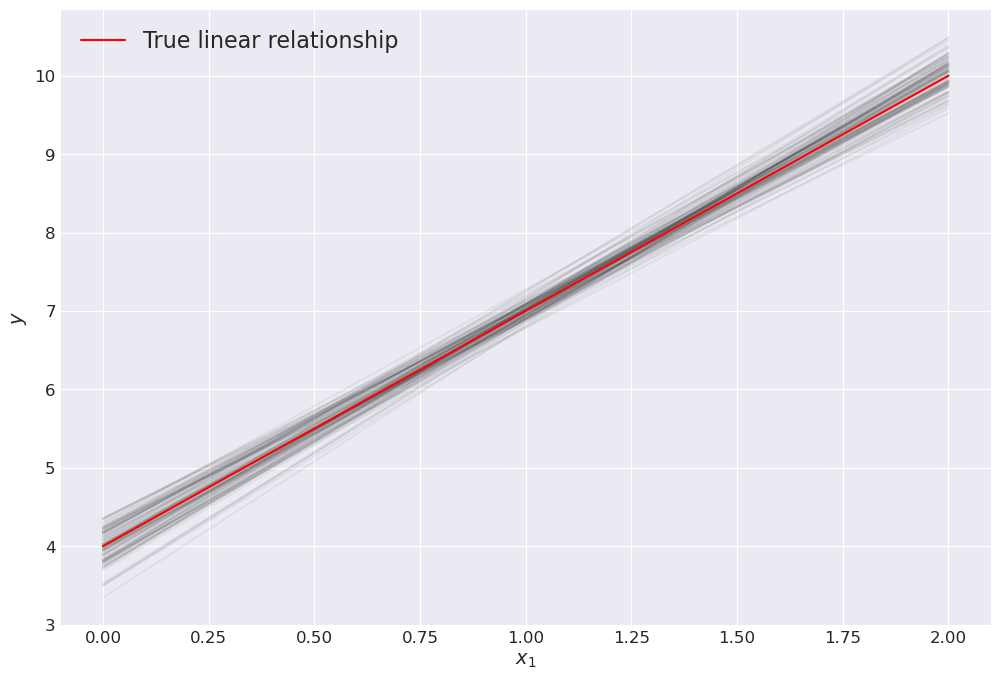

In [61]:
# perform experiment where we sample N times from our population, and fit and plot
# the resulting best fit linear regression model
N = 100
x_ends = np.array([[0.0], [2.0]])
for n in range(N):
    X = 2.0 * np.random.rand(100, 1)
    y = 4.0 + 3.0 * X
    y = y + np.random.randn(100, 1)
    slope, intercept = np.polyfit(X.flatten(), y, 1)
    y_fit = intercept + slope * x_ends
    plt.plot(x_ends, y_fit, 'black', alpha=0.05)
    
# plot the true linear relationship
y_actual = 4.0 + 3.0 * x_ends
plt.plot(x_ends, y_actual, 'red', label='True linear relationship')
plt.xlabel('$x_1$')
plt.ylabel('$y$');
plt.legend(fontsize=16);

Again it would be useful to know some basic statistics to understand this deeply.  But
we can estimate this exact same confidence band on the true linear relationship
by also analyzing the variance of the items we get with a single sample, which is how
these intervals are calculated on plots like the Seaborn `lmplot()`

### Computational Complexity

One of the main reasons that the normal equation is not used in regular practice, especially
for big data and large ML systems, is that it does not scale well as the number
of features grows.  The matrix inversion algorithm is easily implemented
as an $\mathcal{O}(n^3)$, though the best algorithms are known to be about
$\mathcal{O}(n^{2.4})$.  It is the matrix inversion that can make
using the normal equation intractable for large datasets.  The time complexity
means that when you increase the number of features by 2, the computation time
to compute the solution using the normal equation will increase by a factor of
5 to 8.

Both the normal equation, and SVD approaches that compute the pseudo-inverse
get very slow when the number of features grows large (e.g. 10,000 or more).
On the other hand, both are linear with regards to the number
of instances in the training data (they are $\mathcal{O}(m)$), so they handle
large training sets efficiently, provided they can fit in memory.

Also once you have learned the model, whether using the normal equation or the next
method we will look at, making predictions on new data is very fast.  It is linear
with regards to the number of features to make fectorized predictions once you have
a set of $\theta$ parameters for your predictor.

Becausing of computational issues with linear regression, and for many other
analytic approaches to ML learning, an alternative approach for training
is usually used instead.